In [1]:
%matplotlib inline

# Quantum models as Fourier series

This demonstration is based on the paper *The effect of data encoding on
the expressive power of variational quantum machine learning models* by
[Schuld, Sweke, and Meyer (2020)](https://arxiv.org/abs/2008.08605).

![](images/scheme_thumb.png)

The paper links common quantum machine learning models designed for
near-term quantum computers to Fourier series (and, in more general, to
Fourier-type sums). With this link, the class of functions a quantum
model can learn (i.e., its \"expressivity\") can be characterized by the
model\'s control of the Fourier series\' frequencies and coefficients.


## Background



Ref. considers quantum machine learning models of the form

$$f_{\boldsymbol \theta}(x) = \langle 0| U^{\dagger}(x,\boldsymbol \theta) M U(x, \boldsymbol \theta) | 0 \rangle$$

where $M$ is a measurement observable and $U(x, \boldsymbol \theta)$ is
a variational quantum circuit that encodes a data input $x$ and depends
on a set of parameters $\boldsymbol \theta$. Here we will restrict
ourselves to one-dimensional data inputs, but the paper motivates that
higher-dimensional features simply generalize to multi-dimensional
Fourier series.

The circuit itself repeats $L$ layers, each consisting of a
data-encoding circuit block $S(x)$ and a trainable circuit block
$W(\boldsymbol \theta)$ that is controlled by the parameters
$\boldsymbol \theta$. The data encoding block consists of gates of the
form $\mathcal{G}(x) = e^{-ix H}$, where $H$ is a Hamiltonian. A
prominent example of such gates are Pauli rotations.


The paper shows how such a quantum model can be written as a
Fourier-type sum of the form

$$f_{ \boldsymbol \theta}(x) = \sum_{\omega \in \Omega} c_{\omega}( \boldsymbol \theta) \; e^{i  \omega x}.$$

As illustrated in the picture below (which is Figure 1 from the paper),
the \"encoding Hamiltonians\" in $S(x)$ determine the set $\Omega$ of
available \"frequencies\", and the remainder of the circuit, including
the trainable parameters, determines the coefficients $c_{\omega}$.

![](images/scheme.png)

The paper demonstrates many of its findings for circuits in which
$\mathcal{G}(x)$ is a single-qubit Pauli rotation gate. For example, it
shows that $r$ repetitions of a Pauli rotation-encoding gate in
\"sequence\" (on the same qubit, but with multiple layers $r=L$) or in
\"parallel\" (on $r$ different qubits, with $L=1$) creates a quantum
model that can be expressed as a *Fourier series* of the form

$$f_{ \boldsymbol \theta}(x) = \sum_{n \in \Omega} c_{n}(\boldsymbol \theta) e^{i  n x},$$

where $\Omega = \{ -r, \dots, -1, 0, 1, \dots, r\}$ is a spectrum of
consecutive integer-valued frequencies up to degree $r$.

As a result, we expect quantum models that encode an input $x$ by $r$
Pauli rotations to only be able to fit Fourier series of at most degree
$r$.


## Goal of this demonstration



The experiments below investigate this \"Fourier-series\"-like nature of quantum models by showing how to reproduce the simulations underlying Figures 3, 4 and 5 in Section II of the paper:

-   **Figures 3 and 4** are function-fitting experiments, where quantum
    models with different encoding strategies have the task to fit
    Fourier series up to a certain degree. As in the paper, we will use
    examples of qubit-based quantum circuits where a single data feature
    is encoded via Pauli rotations.
-   **Figure 5** plots the Fourier coefficients of randomly sampled
    instances from a family of quantum models which is defined by some
    parametrized ansatz.

The code is presented so you can easily modify it in order to play around with other settings and models. The settings used in the paper are given in the various subsections.


First of all, let\'s make some imports and define a standard loss function for the training.


In [2]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

## Part I: Fitting Fourier series with serial Pauli-rotation encoding



First we will reproduce Figures 3 and 4 from the paper. These show how quantum models that use Pauli rotations as data-encoding gates can only fit Fourier series up to a certain degree. The degree corresponds to the
number of times that the Pauli gate gets repeated in the quantum model.

Let us consider circuits where the encoding gate gets repeated sequentially (as in Figure 2a of the paper). For simplicity we will only look at single-qubit circuits:

![](images/single_qubit_model.png)


### Define a target function



We first define a (classical) target function which will be used as a \"ground truth\" that the quantum model has to fit. The target function is constructed as a Fourier series of a specific degree.

We also allow for a rescaling of the data by a hyperparameter `scaling`, which we will do in the quantum model as well. As shown in, for the quantum model to learn the classical model in the experiment below, the
scaling of the quantum model and the target function have to match, which is an important observation for the design of quantum machine learning models.


In [3]:
degree = 1  # degree of the target function
scaling = 1  # scaling of the data
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

Let\'s have a look at it.


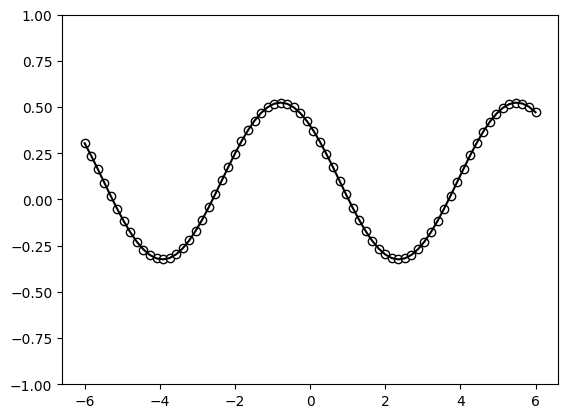

In [4]:
x = np.linspace(-6, 6, 70, requires_grad=False)
target_y = np.array([target_function(x_) for x_ in x], requires_grad=False)

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show();

#### Send it after class

To reproduce the figures in the paper, you can use the following settings in the cells above:

-   For the settings

        degree = 1
        coeffs = (0.15 + 0.15j) * degree 
        coeff0 = 0.1

    this function is the ground truth
    $g(x) = \sum_{n=-1}^1 c_{n} e^{-nix}$ from Figure 3 in the paper.

-   To get the ground truth $g'(x) = \sum_{n=-2}^2 c_{n} e^{-nix}$ with
    $c_0=0.1$, $c_1 = c_2 = 0.15 - 0.15i$ from Figure 3, you need to
    increase the degree to two:

        degree = 2

-   The ground truth from Figure 4 can be reproduced by changing the
    settings to:

        degree = 5 
        coeffs = (0.05 + 0.05j) * degree 
        coeff0 = 0.0 



### Define the serial quantum model



We now define the quantum model itself.


In [5]:
scaling = 1

dev = qml.device('default.qubit', wires=1)

def S(x):
    """Data-encoding circuit block."""
    qml.RX(scaling * x, wires=0)

def W(theta):
    """Trainable circuit block."""
    qml.Rot(theta[0], theta[1], theta[2], wires=0)

    
@qml.qnode(dev)
def serial_quantum_model(weights, x):
    
    for theta in weights[:-1]:
        W(theta)
        S(x)
        
    # (L+1)'th unitary
    W(weights[-1])
    
    return qml.expval(qml.PauliZ(wires=0))

You can run the following cell multiple times, each time sampling
different weights, and therefore different quantum models.


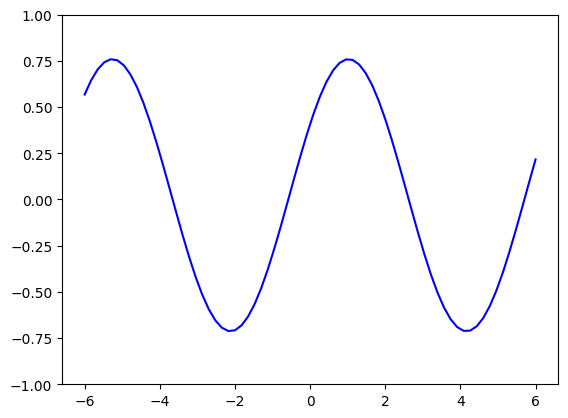

In [6]:
r = 1 # number of times the encoding gets repeated (here equal to the number of layers)
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True) # some random initial weights

x = np.linspace(-6, 6, 70, requires_grad=False)
random_quantum_model_y = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

No matter what weights are picked, the single qubit model for
[L=1]{.title-ref} will always be a sine function of a fixed frequency.
The weights merely influence the amplitude, y-shift, and phase of the
sine.

This observation is formally derived in Section II.A of the paper.


#### Send it after class

Increase the number of layers. Figure 4 from the paper, for example, uses the settings `L=1`, `L=3` and `L=5`. What is the difference?


Finally, let\'s look at the circuit we just created:


In [7]:
print(qml.draw(serial_quantum_model)(weights, x[-1]))

0: ──Rot(2.35,5.97,4.60)──RX(6.00)──Rot(3.76,0.98,0.98)─┤  <Z>


### Fit the model to the target

The next step is to optimize the weights in order to fit the ground
truth.


In [8]:
def cost(weights, x, y):
    predictions = [serial_quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.03212041720004567
Cost at step  20: 0.01385356188302468
Cost at step  30: 0.004049396436389442
Cost at step  40: 0.0005624933894468399
Cost at step  50: 8.145777333271303e-05


To continue training, you may just run the above cell again. Once you are happy, you can use the trained model to predict function values, and compare them with the ground truth.


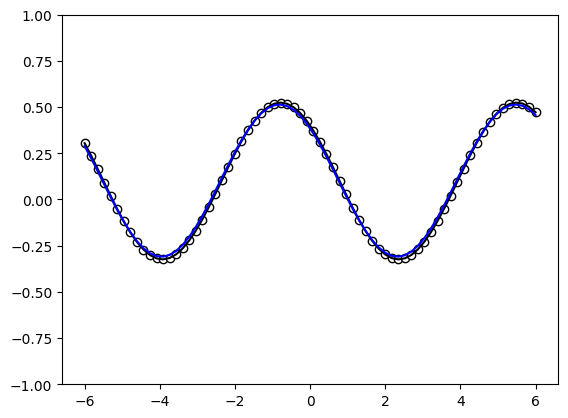

In [9]:
predictions = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show();

Let\'s also have a look at the cost during training.


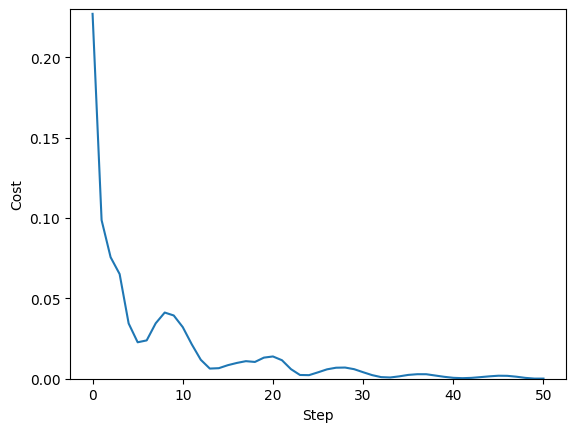

In [10]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.23)
plt.show();

With the initial settings and enough training steps, the quantum model
learns to fit the ground truth perfectly. This is expected, since the
number of Pauli-rotation-encoding gates and the degree of the ground
truth Fourier series are both one.

If the ground truth\'s degree is larger than the number of layers in the
quantum model, the fit will look much less accurate. And finally, we
also need to have the correct scaling of the data: if one of the models
changes the `scaling` parameter (which effectively scales the
frequencies), fitting does not work even with enough encoding
repetitions.


#### Send it after class

What happens for larger L?

Tip: It is an open research question whether for asymptotically large L, the
single qubit model can fit *any* function by constructing arbitrary
Fourier coefficients.


## Part II: Fitting Fourier series with parallel Pauli-rotation encoding



Our next task is to repeat the function-fitting experiment for a circuit
where the Pauli rotation gate gets repeated $r$ times on *different*
qubits, using a single layer $L=1$.

As shown in the paper, we expect similar results to the serial model: a
Fourier series of degree $r$ can only be fitted if there are at least
$r$ repetitions of the encoding gate in the quantum model. However, in
practice this experiment is a bit harder, since the dimension of the
trainable unitaries $W$ grows quickly with the number of qubits.

In the paper, the investigations are made with the assumption that the
purple trainable blocks $W$ are arbitrary unitaries. We could use the
`~.pennylane.templates.ArbitraryUnitary`{.interpreted-text role="class"}
template, but since this template requires a number of parameters that
grows exponentially with the number of qubits ($4^L-1$ to be precise),
this quickly becomes cumbersome to train.

We therefore follow Figure 4 in the paper and use an ansatz for $W$.


![](images/parallel_model.png)

### Define the parallel quantum model



The ansatz is PennyLane\'s layer structure called
`~.pennylane.templates.StronglyEntanglingLayers`, and as the name suggests, it has itself a user-defined
number of layers (which we will call \"ansatz layers\" to avoid
confusion).


In [11]:
from pennylane.templates import StronglyEntanglingLayers

Let\'s have a quick look at the ansatz itself for 3 qubits by making a
dummy circuit of 2 ansatz layers:


In [12]:
n_ansatz_layers = 2
n_qubits = 3

dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def ansatz(weights):
    StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.Identity(wires=0))

weights_ansatz = 2 * np.pi * np.random.random(size=(n_ansatz_layers, n_qubits, 3))
print(qml.draw(ansatz, expansion_strategy="device")(weights_ansatz))

0: ──Rot(1.38,4.29,0.48)─╭●────╭X──Rot(4.26,3.55,1.68)─╭●─╭X────┤  <I>
1: ──Rot(5.35,3.11,3.02)─╰X─╭●─│───Rot(5.52,5.01,4.14)─│──╰●─╭X─┤     
2: ──Rot(3.72,5.18,2.19)────╰X─╰●──Rot(5.34,5.45,4.45)─╰X────╰●─┤     


Now we define the actual quantum model.


In [13]:
scaling = 1
r = 3

dev = qml.device('default.qubit', wires=r)

def S(x):
    """Data-encoding circuit block."""
    for w in range(r):
        qml.RX(scaling * x, wires=w)

def W(theta):
    """Trainable circuit block."""
    StronglyEntanglingLayers(theta, wires=range(r))

    
@qml.qnode(dev)
def parallel_quantum_model(weights, x):
    
    W(weights[0])
    S(x)        
    W(weights[1])
    
    return qml.expval(qml.PauliZ(wires=0))

Again, you can sample random weights and plot the model function:


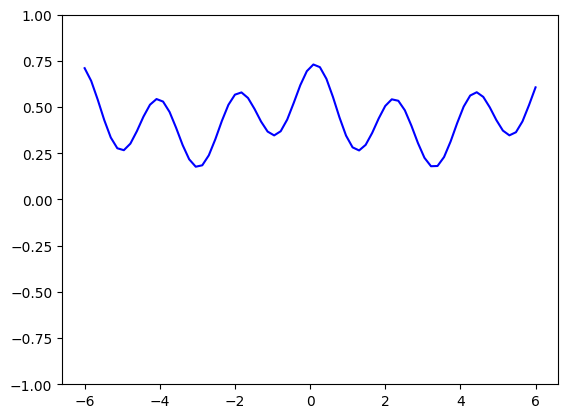

In [14]:
trainable_block_layers = 3
weights = 2 * np.pi * np.random.random(size=(2, trainable_block_layers, r, 3), requires_grad=True)

x = np.linspace(-6, 6, 70, requires_grad=False)
random_quantum_model_y = [parallel_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show();

## Send it after class: Training the model



Training the model is done exactly as before, but it may take a lot
longer this time. We set a default of 25 steps, which you should
increase if necessary. Small models of \<6 qubits usually converge after
a few hundred steps at most---but this depends on your settings.


In [15]:
def cost(weights, x, y):
    predictions =  #fill me
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = # fill me
cst = ##fill me  # initial cost

for step in range(max_steps):

    # select batch of data
    batch_index = ## fill me
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)
    
    # save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

SyntaxError: invalid syntax (3349130107.py, line 2)

In [ ]:
predictions = [parallel_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show();

In [ ]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.show();



To reproduce the right column in Figure 4 from the paper, use the
correct ground truth, $r=3$ and `trainable_block_layers=3`, as well as
sufficiently many training steps. The amount of steps depends on the
initial weights and other hyperparameters, and in some settings training
may not converge to zero error at all.


## Part III: Sampling Fourier coefficients


When we use a trainable ansatz above, it is possible that even with
enough repetitions of the data-encoding Pauli rotation, the quantum
model cannot fit the circuit, since the expressivity of quantum models
also depends on the Fourier coefficients the model can create.

Figure 5 in shows Fourier coefficients from quantum models sampled from
a model family defined by an ansatz for the trainable circuit block. For
this we need a function that numerically computes the Fourier
coefficients of a periodic function f with period $2 \pi$.


In [16]:
def fourier_coefficients(f, K):
    """
    Computes the first 2*K+1 Fourier coefficients of a 2*pi periodic function.
    """
    n_coeffs = 2 * K + 1
    t = np.linspace(0, 2 * np.pi, n_coeffs, endpoint=False)
    y = np.fft.rfft(f(t)) / t.size
    return y

### Define your quantum model



Now we need to define a quantum model. This could be any model, using a
qubit or continuous-variable circuit, or one of the quantum models from
above. We will use a slight derivation of the `parallel_qubit_model()`
from above, this time using the
`~.pennylane.templates.BasicEntanglerLayers` ansatz:


In [17]:
from pennylane.templates import BasicEntanglerLayers

scaling = 1
n_qubits = 4

dev = qml.device('default.qubit', wires=n_qubits)

def S(x):
    """Data encoding circuit block."""
    for w in range(n_qubits):
        qml.RX(scaling * x, wires=w)

def W(theta):
    """Trainable circuit block."""
    BasicEntanglerLayers(theta, wires=range(n_qubits))

    
@qml.qnode(dev)
def quantum_model(weights, x):
    
    W(weights[0])
    S(x)
    W(weights[1])
    
    return qml.expval(qml.PauliZ(wires=0))

It will also be handy to define a function that samples different random
weights of the correct size for the model.


In [18]:
n_ansatz_layers = 1

def random_weights():
    return 2 * np.pi * np.random.random(size=(2, n_ansatz_layers, n_qubits))

Now we can compute the first few Fourier coefficients for samples from
this model. The samples are created by randomly sampling different
parameters using the `random_weights()` function.


In [19]:
n_coeffs = 5
n_samples = 100


coeffs = []
for i in range(n_samples):

    weights = random_weights()

    def f(x):
        return np.array([quantum_model(weights, x_) for x_ in x])

    coeffs_sample = fourier_coefficients(f, n_coeffs)
    coeffs.append(coeffs_sample)

coeffs = np.array(coeffs)
coeffs_real = np.real(coeffs)
coeffs_imag = np.imag(coeffs)

Let\'s plot the real vs. the imaginary part of the coefficients. As a
sanity check, the $c_0$ coefficient should be real, and therefore have
no contribution on the y-axis.


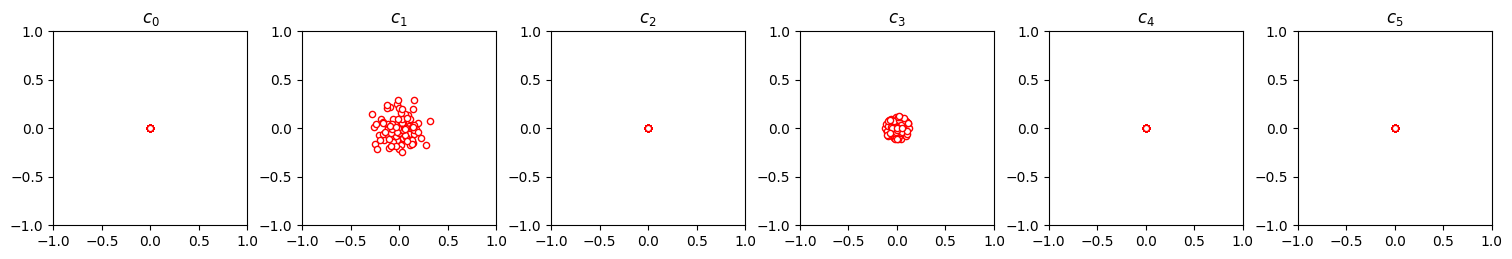

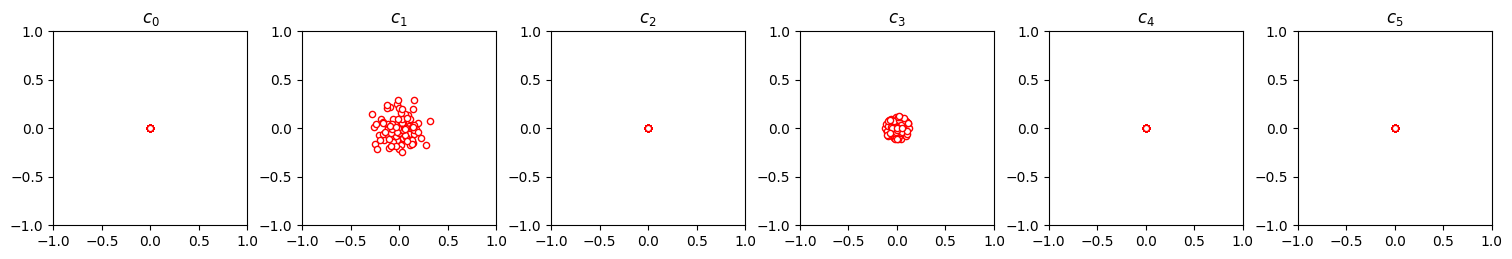

In [21]:
n_coeffs = len(coeffs_real[0])

fig, ax = plt.subplots(1, n_coeffs, figsize=(15, 4))

for idx, ax_ in enumerate(ax):
    ax_.set_title(r"$c_{}$".format(idx))
    ax_.scatter(coeffs_real[:, idx], coeffs_imag[:, idx], s=20, 
                facecolor='white', edgecolor='red')
    ax_.set_aspect("equal")
    ax_.set_ylim(-1, 1)
    ax_.set_xlim(-1, 1)


plt.tight_layout(pad=0.5)
plt.show();

Playing around with different quantum models, you will find that some
quantum models create different distributions over the coefficients than
others. For example `BasicEntanglingLayers` (with the default Pauli-X
rotation) seems to have a structure that forces the even Fourier
coefficients to zero, while `StronglyEntanglingLayers` will have a
non-zero variance for all supported coefficients.

Note also how the variance of the distribution decreases for growing
orders of the coefficients---an effect linked to the convergence of a
Fourier series.


### Send it after class

To reproduce the results from Figure 5 you have to change the ansatz (no
unitary, `BasicEntanglerLayers` or `StronglyEntanglingLayers`, and set
`n_ansatz_layers` either to $1$ or $5$). The `StronglyEntanglingLayers`
requires weights of shape `size=(2, n_ansatz_layers, n_qubits, 3)`.



## Continuous-variable model


Ref. mentions that a phase rotation in continuous-variable quantum
computing has a spectrum that supports *all* Fourier frequecies. To play
with this model, we finally show you the code for a continuous-variable
circuit. For example, to see its Fourier coefficients run the cell
below, and then re-run the two cells above.


In [23]:
var = 2
n_ansatz_layers = 1
dev_cv = qml.device('default.gaussian', wires=1)

def S(x):
    qml.Rotation(x, wires=0)

def W(theta):
    """Trainable circuit block."""
    for r_ in range(n_ansatz_layers):
        qml.Displacement(theta[0], theta[1], wires=0)
        qml.Squeezing(theta[2], theta[3], wires=0)

@qml.qnode(dev_cv)
def quantum_model(weights, x):
    W(weights[0])
    S(x)
    W(weights[1])
    return qml.expval(qml.X(wires=0))

def random_weights():
    return np.random.normal(size=(2, 5 * n_ansatz_layers), loc=0, scale=var)

### Send it after class
To find out what effect so-called \"non-Gaussian\" gates like the `Kerr`
gate have, you need to install the [strawberryfields
plugin](https://pennylane-sf.readthedocs.io/en/latest/) and change the
device to

``` {.python}
dev_cv = qml.device('strawberryfields.fock', wires=1, cutoff_dim=50)
```



# Data-reuploading classifier


A single-qubit quantum circuit which can implement arbitrary unitary
operations can be used as a universal classifier much like a single
hidden-layered Neural Network. As surprising as it sounds,
[Pérez-Salinas et al. (2019)](https://arxiv.org/abs/1907.02085) discuss
this with their idea of \'data reuploading\'. It is possible to load a
single qubit with arbitrary dimensional data and then use it as a
universal classifier.

In this example, we will implement this idea with Pennylane - a python
based tool for quantum machine learning, automatic differentiation, and
optimization of hybrid quantum-classical computations.

## Background


We consider a simple classification problem and will train a
single-qubit variational quantum circuit to achieve this goal. The data
is generated as a set of random points in a plane $(x_1, x_2)$ and
labeled as 1 (blue) or 0 (red) depending on whether they lie inside or
outside a circle. The goal is to train a quantum circuit to predict the
label (red or blue) given an input point\'s coordinate.

![](images/universal_circles.png)

## Transforming quantum states using unitary operations

A single-qubit quantum state is characterized by a two-dimensional state
vector and can be visualized as a point in the so-called Bloch sphere.
Instead of just being a 0 (up) or 1 (down), it can exist in a
superposition with say 30% chance of being in the $|0 \rangle$ and 70%
chance of being in the $|1 \rangle$ state. This is represented by a
state vector
$|\psi \rangle = \sqrt{0.3}|0 \rangle + \sqrt{0.7}|1 \rangle$ -the
probability \"amplitude\" of the quantum state. In general we can take a
vector $(\alpha, \beta)$ to represent the probabilities of a qubit being
in a particular state and visualize it on the Bloch sphere as an arrow.

![](../demonstrations/data_reuploading/universal_bloch.png)

## Data loading using unitaries

In order to load data onto a single qubit, we use a unitary operation
$U(x_1, x_2, x_3)$ which is just a parameterized matrix multiplication
representing the rotation of the state vector in the Bloch sphere. E.g.,
to load $(x_1, x_2)$ into the qubit, we just start from some initial
state vector, $|0 \rangle$, apply the unitary operation $U(x_1, x_2, 0)$
and end up at a new point on the Bloch sphere. Here we have padded 0
since our data is only 2D. Pérez-Salinas et al. (2019) discuss how to
load a higher dimensional data point ($[x_1, x_2, x_3, x_4, x_5, x_6]$)
by breaking it down in sets of three parameters
($U(x_1, x_2, x_3), U(x_4, x_5, x_6)$).

## Model parameters with data re-uploading

Once we load the data onto the quantum circuit, we want to have some
trainable nonlinear model similar to a neural network as well as a way
of learning the weights of the model from data. This is again done with
unitaries, $U(\theta_1, \theta_2, \theta_3)$, such that we load the data
first and then apply the weights to form a single layer
$L(\vec \theta, \vec x) = U(\vec \theta)U(\vec x)$. In principle, this
is just application of two matrix multiplications on an input vector
initialized to some value. In order to increase the number of trainable
parameters (similar to increasing neurons in a single layer of a neural
network), we can reapply this layer again and again with new sets of
weights,
$L(\vec \theta_1, \vec x) L(\vec \theta_2, , \vec x) ... L(\vec \theta_L, \vec x)$
for $L$ layers. The quantum circuit would look like the following:

![](images/universal_layers.png)

## The cost function and \"nonlinear collapse\"

So far, we have only performed linear operations (matrix
multiplications) and we know that we need to have some nonlinear
squashing similar to activation functions in neural networks to really
make a universal classifier (Cybenko 1989). Here is where things gets a
bit quantum. After the application of the layers, we will end up at some
point on the Bloch sphere due to the sequence of unitaries implementing
rotations of the input. These are still just linear transformations of
the input state. Now, the output of the model should be a class label
which can be encoded as fixed vectors (Blue = $[1, 0]$, Red = $[0, 1]$)
on the Bloch sphere. We want to end up at either of them after
transforming our input state through alternate applications of data
layer and weights.

We can use the idea of the \"collapse\" of our quantum state into one or
other class. This happens when we measure the quantum state which leads
to its projection as either the state 0 or 1. We can compute the
fidelity (or closeness) of the output state to the class label making
the output state jump to either $| 0 \rangle$ or $|1\rangle$. By
repeating this process several times, we can compute the probability or
overlap of our output to both labels and assign a class based on the
label our output has a higher overlap. This is much like having a set of
output neurons and selecting the one which has the highest value as the
label.

We can encode the output label as a particular quantum state that we
want to end up in and use Pennylane to find the probability of ending up
in that state after running the circuit. We construct an observable
corresponding to the output label using the
[Hermitian](https://pennylane.readthedocs.io/en/latest/code/ops/qubit.html#pennylane.ops.qubit.Hermitian)
operator. The expectation value of the observable gives the overlap or
fidelity. We can then define the cost function as the sum of the
fidelities for all the data points after passing through the circuit and
optimize the parameters $(\vec \theta)$ to minimize the cost.

$$\texttt{Cost} = \sum_{\texttt{data points}} (1 - \texttt{fidelity}(\psi_{\texttt{output}}(\vec x, \vec \theta), \psi_{\texttt{label}}))$$

Now, we can use our favorite optimizer to maximize the sum of the
fidelities over all data points (or batches of datapoints) and find the
optimal weights for classification. Gradient-based optimizers such as
Adam (Kingma et. al., 2014) can be used if we have a good model of the
circuit and how noise might affect it. Or, we can use some gradient-free
method such as L-BFGS (Liu, Dong C., and Nocedal, J., 1989) to evaluate
the gradient and find the optimal weights where we can treat the quantum
circuit as a black-box and the gradients are computed numerically using
a fixed number of function evaluations and iterations. The L-BFGS method
can be used with the PyTorch interface for Pennylane.

## Multiple qubits, entanglement and Deep Neural Networks

The Universal Approximation Theorem declares that a neural network with
two or more hidden layers can serve as a universal function
approximator. Recently, we have witnessed remarkable progress of
learning algorithms using Deep Neural Networks.

Pérez-Salinas et al. (2019) make a connection to Deep Neural Networks by
describing that in their approach the \"layers\"
$L_i(\vec \theta_i, \vec x )$ are analogous to the size of the
intermediate hidden layer of a neural network. And the concept of deep
(multiple layers of the neural network) relates to the number of qubits.
So, multiple qubits with entanglement between them could provide some
quantum advantage over classical neural networks. But here, we will only
implement a single qubit classifier.

![](images/universal_dnn.png)

## \"Talk is cheap. Show me the code.\" - Linus Torvalds



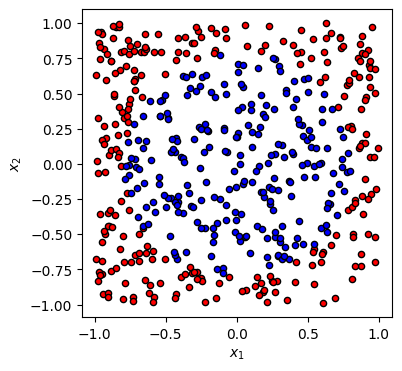

In [24]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt


# Set a random seed
np.random.seed(42)


# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


Xdata, ydata = circle(500)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

### Simple classifier with data reloading and fidelity loss

In [25]:
dev = qml.device("default.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

### Utility functions for testing and creating batches


In [26]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

### Train a quantum classifier on the circle dataset


In [27]:
# Generate training and test data
num_training = 200
num_test = 2000

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.415535 | Train accuracy: 0.460000 | Test Accuracy: 0.448500
Epoch:  1 | Loss: 0.125417 | Train accuracy: 0.840000 | Test accuracy: 0.804000
Epoch:  2 | Loss: 0.154322 | Train accuracy: 0.775000 | Test accuracy: 0.756000
Epoch:  3 | Loss: 0.145234 | Train accuracy: 0.810000 | Test accuracy: 0.799000
Epoch:  4 | Loss: 0.126142 | Train accuracy: 0.805000 | Test accuracy: 0.781500
Epoch:  5 | Loss: 0.127102 | Train accuracy: 0.845000 | Test accuracy: 0.794500
Epoch:  6 | Loss: 0.128556 | Train accuracy: 0.825000 | Test accuracy: 0.807000
Epoch:  7 | Loss: 0.113327 | Train accuracy: 0.810000 | Test accuracy: 0.794500
Epoch:  8 | Loss: 0.109549 | Train accuracy: 0.895000 | Test accuracy: 0.857000
Epoch:  9 | Loss: 0.147936 | Train accuracy: 0.750000 | Test accuracy: 0.750000
Epoch: 10 | Loss: 0.104038 | Train accuracy: 0.890000 | Test accuracy: 0.847000


### Results

Cost: 0.104038 | Train accuracy 0.890000 | Test Accuracy : 0.847000
Learned weights
Layer 0: [-0.23838965  1.17081693 -0.19781887]
Layer 1: [0.64850867 0.71778245 0.46408056]
Layer 2: [ 2.39560597 -1.21404538  0.32099705]


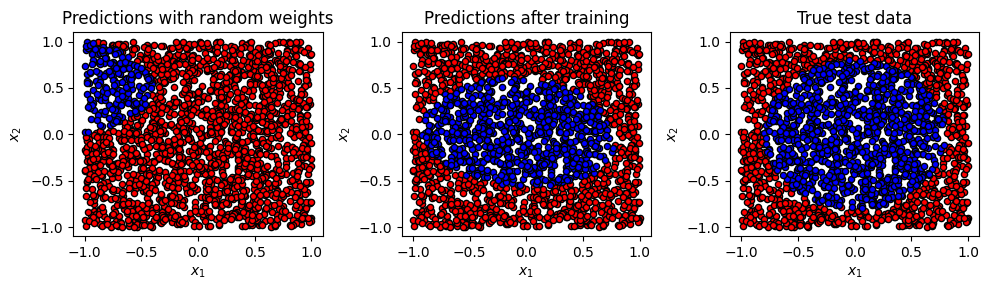

In [28]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

## Send it after class

Try improving the accuracy.

## References


\[1\] Pérez-Salinas, Adrián, et al. \"Data re-uploading for a universal
quantum classifier.\" arXiv preprint arXiv:1907.02085 (2019).

\[2\] Kingma, Diederik P., and Ba, J. \"Adam: A method for stochastic
optimization.\" arXiv preprint arXiv:1412.6980 (2014).

\[3\] Liu, Dong C., and Nocedal, J. \"On the limited memory BFGS method
for large scale optimization.\" Mathematical programming 45.1-3 (1989):
503-528.

